In [ ]:
!pip install catboost

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from datetime import datetime, date, time
import seaborn as sns
import os
import pandas as pd
from scipy.stats import spearmanr
import scipy.stats
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
from torch import nn
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, Ridge
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import sklearn

In [23]:
with open('/content/drive/MyDrive/bd_git/dataset.csv') as f:
    df = pd.read_csv(f, index_col=0)

Проверим признаки на мультиколлинеарность

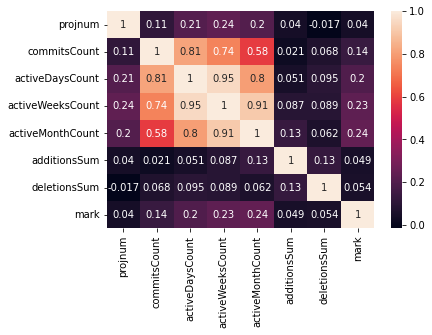

In [24]:
sns.heatmap(df.corr(), annot = True);

Заметим, что признаки активных дней, недель и месяцев сильно коррелируют между собой. Использование всех трех признаков может привести к неустойчивости нашей модели, поэтому оставим из них только один, наиболее сильно коррелирующий с целевой переменной - признак activeMonthCount  

In [25]:
df = df.drop(labels=['student', 'projnum', 'commitsСount', 'activeDaysCount', 'activeWeeksCount'], axis=1)

In [26]:
df

,activeMonthCount,additionsSum,deletionsSum,mark
0,6,5329,383,4
1,5,31363,46883,8
2,3,186,34,8
3,1,850206,0,8
4,3,68927,6764,9
...,...,...,...,...
212,1,1300,563,7
213,1,3,0,7
214,1,157,0,4
215,1,1185,0,8


Проверим, есть ли в гаших данных выбросы, которые будут создавать проблемы при регрессии

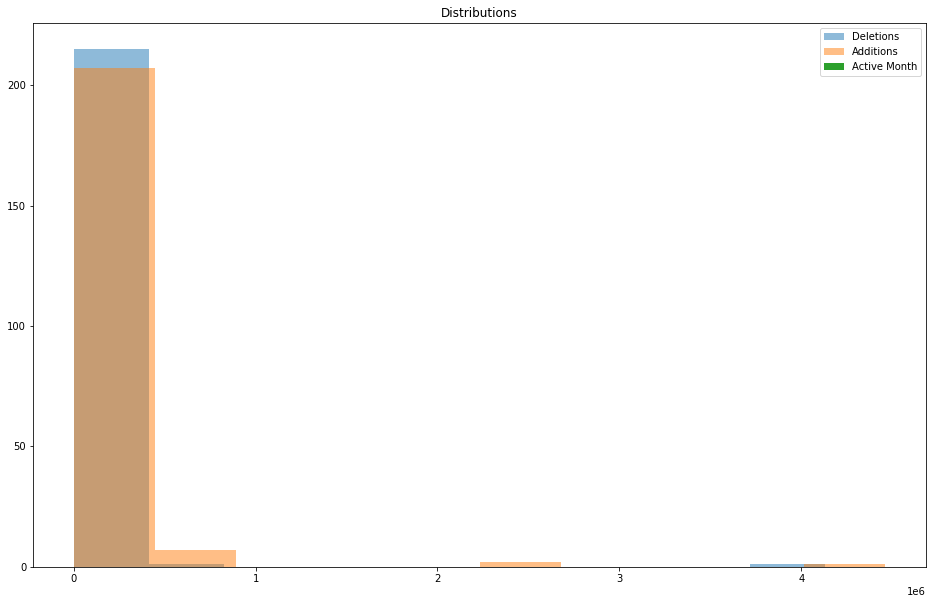

In [27]:
plt.figure(figsize=(16, 10))
plt.title("Distributions")

plt.hist(df['deletionsSum'], label="Deletions", linewidth=2, alpha=0.5)
plt.hist(df['additionsSum'], label="Additions", linewidth=2, alpha = 0.5,)
plt.hist(df['activeMonthCount'], label="Active Month", linewidth=2)

plt.legend()
plt.show()

Можем заметить явные выбросы в признаках deletionsSum и additionsSum.
Удалим строки, в которых значения этих признаков > 2e6

In [28]:
df[(df['additionsSum'] > 2e6) | (df['deletionsSum'] > 2e6)]

,activeMonthCount,additionsSum,deletionsSum,mark
59,3,209668,4133078,8
90,1,2566128,2953,6
134,6,4463183,495757,7
176,5,2549725,81865,8


In [29]:
df = df.drop(df[(df['additionsSum'] > 2e6) | (df['deletionsSum'] > 2e6)].index)

# Standartization

Разделим нашу выборку на обучающую и тестовую

In [30]:
y = df['mark']
X = df.drop(['mark'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

Стандартизируем признаки

In [31]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test) 

# Linear Regression

В качестве бейзлайна построим модель линейной регрессии с Ridge регуляризацией и посмотрим на результаты



In [32]:
ridge_lg = Ridge()

In [33]:
parameters = {'alpha':[1, 10, 15, 17, 20, 25, 28, 30, 35, 40]}
Ridge_reg= GridSearchCV(ridge_lg, parameters, scoring='neg_mean_squared_error',cv=5)

Ridge_reg.fit(X_train,y_train)

print(Ridge_reg.best_estimator_)

Ridge(alpha=1)


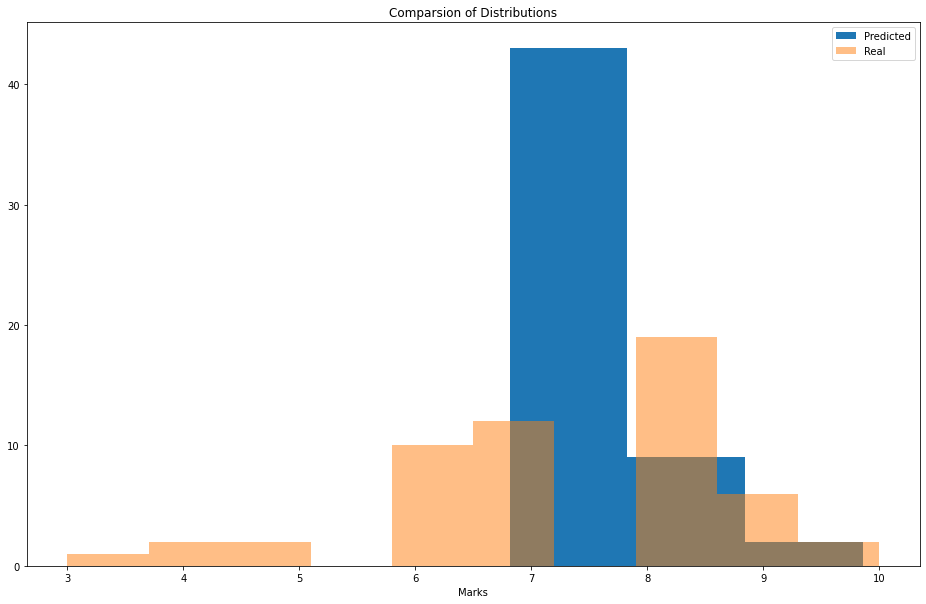

In [34]:
plt.figure(figsize=(16, 10))
plt.title("Comparsion of Distributions")
plt.hist(Ridge_reg.predict(X_test), label="Predicted", linewidth=2, bins=3)
plt.hist(y_test, label="Real", linewidth=2, alpha = 0.5,)

plt.legend()
plt.xlabel("Marks")
plt.show()

In [94]:
print(f"RMSE - {mean_squared_error(y_test, Ridge_reg.predict(X_test), squared=False)}")
print(f"Real mean - {y_test.mean()} Pred mean - {Ridge_reg.predict(X_test).mean()}")
print(f"Real std - {y_test.std()} Pred std - {Ridge_reg.predict(X_test).std()}")

RMSE - 1.454228022022908
Real mean - 7.2407407407407405 Pred mean - 7.281212995809727
Real std - 1.439800630658538 Pred std - 0.6183370856378602


Как мы можем заметить, полученная модель - несмещенная, однако вариативность полученных оценок маленькая

Модель линейной регрессии с L2 регуляризацией плохо справилась с задачей из-за небольшой вариативности предсказнных оценок

# CatBoost Regressor

In [36]:
cat = CatBoostRegressor()

Подберем гиперпараметры модели

In [37]:
params = {'iterations': [500],
          'depth': [9, 12, 15],
          'loss_function': ['RMSE','MAE'],
          'l2_leaf_reg': np.logspace(-20, -19, 3),
          'leaf_estimation_iterations': [10],
          'logging_level':['Silent'],
          'random_seed': [42]
         }
scorer = make_scorer(mean_squared_error)
clf_grid = GridSearchCV(estimator=cat, param_grid=params, scoring=scorer, cv=5)

In [38]:
clf_grid.fit(X_train, y_train)
best_param = clf_grid.best_params_
best_param

{'depth': 12,
 'iterations': 500,
 'l2_leaf_reg': 1e-20,
 'leaf_estimation_iterations': 10,
 'logging_level': 'Silent',
 'loss_function': 'RMSE',
 'random_seed': 42}

Используем модель с лучшими парамерами

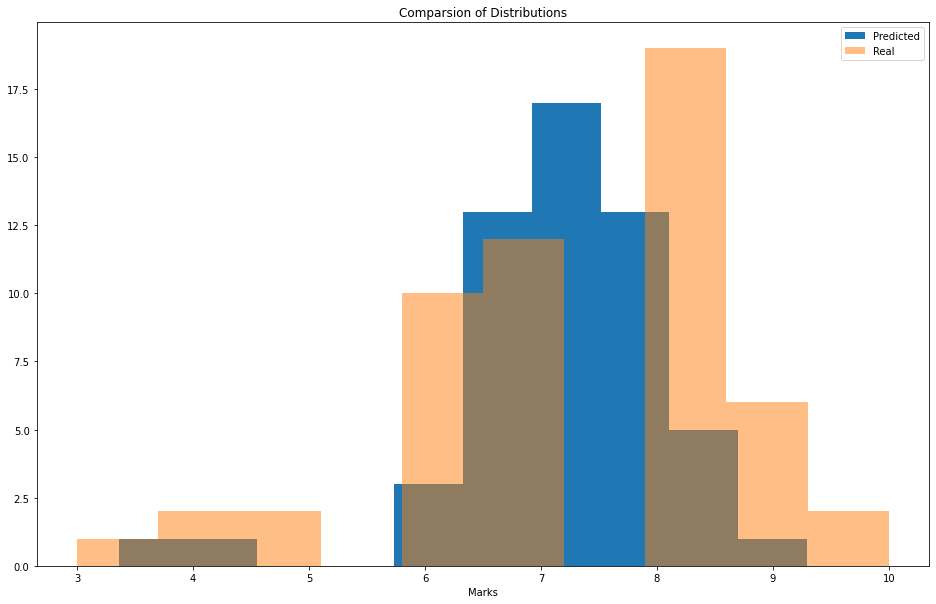

In [97]:
plt.figure(figsize=(16, 10))
plt.title("Comparsion of Distributions")
plt.hist(clf_grid.best_estimator_.predict(X_test), label="Predicted", linewidth=2, bins=10)
plt.hist(y_test, label="Real", linewidth=2, bins=10, alpha = 0.5,)

plt.legend()
plt.xlabel("Marks")
plt.show()


In [99]:
print(f"RMSE - {mean_squared_error(y_test, clf_grid.best_estimator_.predict(X_test), squared=False)}")
print(f"Real mean - {y_test.mean()} Pred mean - {clf_grid.best_estimator_.predict(X_test).mean()}")
print(f"Real std - {y_test.std()} Pred std - {clf_grid.best_estimator_.predict(X_test).std()}")

RMSE - 1.6650760375483638
Real mean - 7.2407407407407405 Pred mean - 7.150351393952526
Real std - 1.439800630658538 Pred std - 0.9565633113121118


Модель градиентного бустинга показала лучший результат засчет большей вариативности предсказываемых оценок. Также она является несмещенной 